In [1]:
import os, sys
# for accessing src, stan, etc.
sys.path.append(os.path.abspath(os.path.join("../..")))

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from src.models.HmmEam import model, configurator, constrain_parameters
from amortizer import amortizer

from cmdstanpy import CmdStanModel
from logging import getLogger

stan_logger = getLogger("cmdstanpy")
stan_logger.disabled = True

/Users/simonkucharsky/projects/bayesflow/amortized-mixture/.venv/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 8)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 400, 3)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:Loaded loss history from checkpoints/amortizer/history_52.pkl.
INFO:root:Networks loaded from checkpoints/amortizer/ckpt-52
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [2]:
stan_model = CmdStanModel(stan_file="../../stan/hmm-eam.stan")

In [3]:
true_params = np.array([[0.9, 0.9, 0.7, 2.5, 4.0, 3.0, 6.0, 0.2]])


# df = configurator(model(1))

df = model.simulator(params=true_params)
df['prior_draws'] = true_params

df = configurator(df)


rt = np.array(df['posterior_inputs']['summary_conditions'][0,:,0]).astype(np.float32)
choice = 1+np.array(tf.argmax(df['posterior_inputs']['summary_conditions'][0,:,1:], axis=-1)).astype(np.int32)
state = np.array(tf.argmax(df['mixture_inputs']['latents'][0,0], axis=-1))
n_obs = rt.shape[0]
y = [(c, r) for c, r in zip(choice, rt)]

stan_df = {
    "n_obs": n_obs,
    "y": y
}

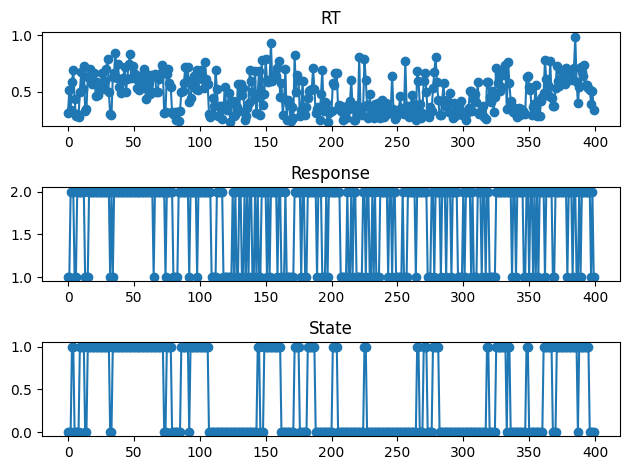

In [4]:
fig, axs = plt.subplots(nrows=3)

axs[0].set_title("RT")
axs[1].set_title("Response")
axs[2].set_title("State")


f=axs[0].plot(rt)
f=axs[0].scatter(range(n_obs), rt)

f=axs[1].plot(choice)
f=axs[1].scatter(range(n_obs), choice)

f=axs[2].plot(state)
f=axs[2].scatter(range(n_obs), state)

fig.tight_layout()

In [5]:
bf_unconstrained_posterior, (bf_forward, bf_backward, bf_smoothing) = amortizer.sample(df, n_samples=4000)
bf_unconstrained_posterior = bf_unconstrained_posterior[0]
bf_forward = bf_forward[0]
bf_backward = bf_backward[0]
bf_smoothing = bf_smoothing[0]
rts = np.expand_dims(rt, axis=0)
rts = np.tile(rts, [4000, 1])
bf_posterior = constrain_parameters(bf_unconstrained_posterior, rts)


In [6]:
stan_fit = stan_model.sample(stan_df, adapt_delta=0.99, show_progress=False)
print(stan_fit.diagnose())

Processing csv files: /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmprfabru1g/hmm-eamxxj_uiq6/hmm-eam-20240823075952_1.csv, /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmprfabru1g/hmm-eamxxj_uiq6/hmm-eam-20240823075952_2.csv, /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmprfabru1g/hmm-eamxxj_uiq6/hmm-eam-20240823075952_3.csv, /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmprfabru1g/hmm-eamxxj_uiq6/hmm-eam-20240823075952_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [7]:
stan_posterior = np.array([
    stan_fit.stan_variables()['transition_matrix'][:, 0, 0],
    stan_fit.stan_variables()['transition_matrix'][:, 1, 1],
    stan_fit.stan_variables()['alpha_1'],
    stan_fit.stan_variables()['alpha_2'],
    stan_fit.stan_variables()['nu_1'],
    stan_fit.stan_variables()['nu_2'][:,0],
    stan_fit.stan_variables()['nu_2'][:,1],
    stan_fit.stan_variables()['tau'],

]).transpose()

In [8]:
stan_forward = stan_fit.stan_variables()["filtering"]
stan_smoothing = stan_fit.stan_variables()["smoothing"]

In [9]:
forward = np.array([bf_forward, stan_forward])
smoothing = np.array([bf_smoothing, stan_smoothing])

forward = np.quantile(forward, q = [0.005, 0.5, 0.995], axis=1)
smoothing = np.quantile(smoothing, q = [0.005, 0.5, 0.995], axis=1)

In [10]:
prior = model.prior(20_000)['prior_draws']

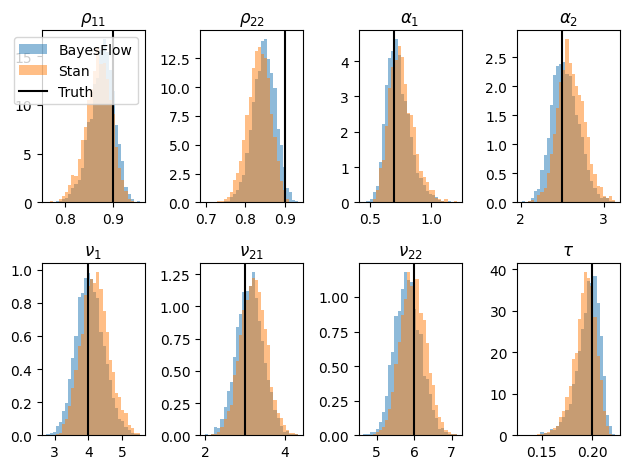

In [11]:
fig, axs = plt.subplots(ncols=4, nrows=2)
axs = axs.flatten()

bins = [
    np.linspace(np.min(bf_posterior[:,i]), np.max(bf_posterior[:,i]), 31) for i in range(8)
]
for i, par in enumerate(model.param_names['constrained']):
    axs[i].hist(bf_posterior[:,i], bins = bins[i], alpha=0.5, density=True, label = "BayesFlow")
    axs[i].hist(stan_posterior[:,i], bins = bins[i], alpha=0.5, density=True, label = "Stan")
    #axs[i].hist(prior[:,i], bins = bins[i], alpha=0.3, density=True, label = "Prior")
    axs[i].axvline(true_params[0,i], c='black', label="Truth")
    axs[i].set_title(par)

axs[0].legend()
fig.tight_layout()

In [12]:
plt.rcParams['figure.figsize'] = [10, 10]

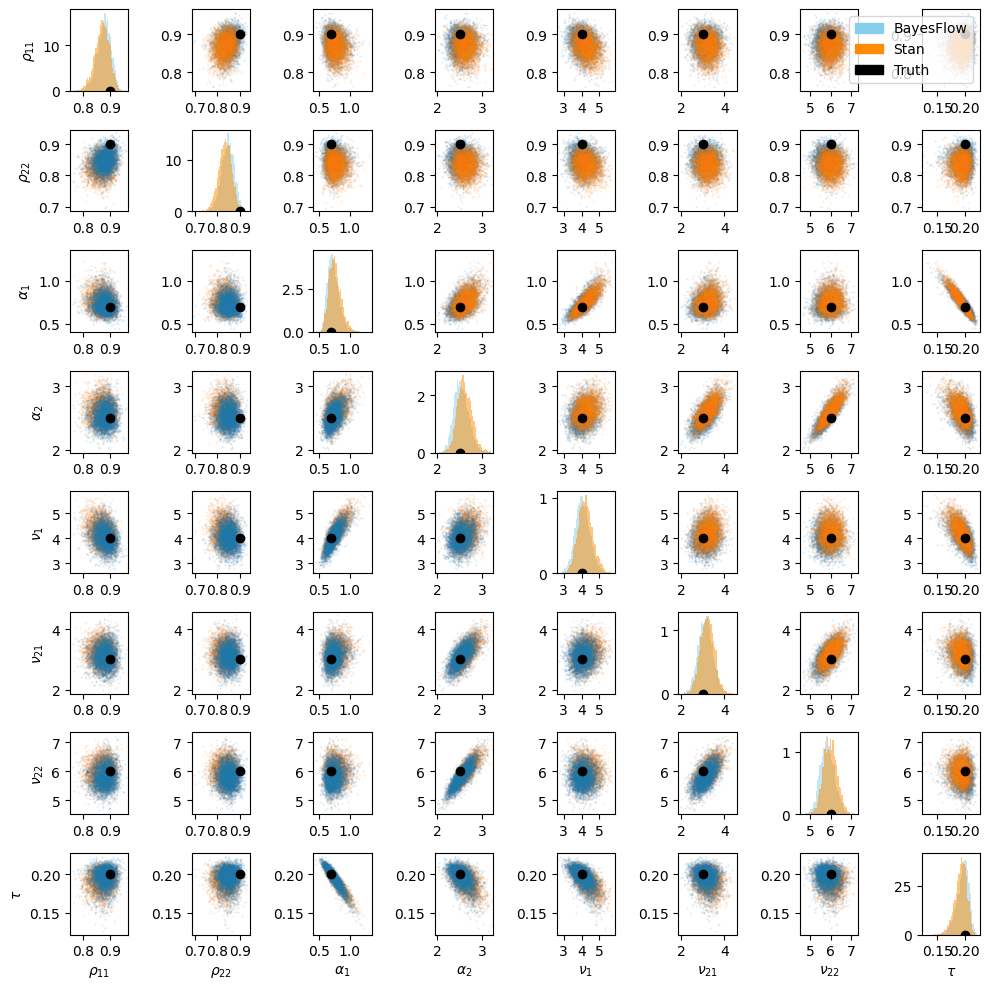

In [13]:
fig, axs = plt.subplots(nrows=len(model.param_names['constrained']), ncols=len(model.param_names['constrained']))

bins = [
    np.linspace(np.min(bf_posterior[:,i])-0.1, np.max(bf_posterior[:,i])+0.1, 36) for i in range(6)
]

handles = [
    patches.Patch(color='skyblue'),
    patches.Patch(color='darkorange'),
    patches.Patch(color='black')
]
for xi, x_par in enumerate(model.param_names['constrained']):
    axs[-1,xi].set_xlabel(x_par)
    for yi, y_par in enumerate(model.param_names['constrained']):
        if xi == yi:
            axs[yi,0].set_ylabel(y_par)
            axs[yi,xi].hist(bf_posterior[:,xi], bins=40,alpha = 0.5, density=True, color="skyblue")
            axs[yi,xi].hist(stan_posterior[:,xi], bins=40,alpha = 0.5, density=True, color="darkorange")
            axs[yi,xi].scatter(true_params[0,xi], 0, color="black", label="Truth")
        elif xi > yi:
            axs[yi,xi].scatter(bf_posterior[:,xi], bf_posterior[:,yi], s=0.5, alpha=0.1, label="skyblue")
            axs[yi,xi].scatter(stan_posterior[:,xi], stan_posterior[:,yi], s=0.5, alpha=0.1, label="darkorange")
            axs[yi,xi].scatter(true_params[0,xi], true_params[0,yi], color="black")
        else:
            axs[yi,xi].scatter(bf_posterior[:,xi], bf_posterior[:,yi], s=0.5, alpha=0.1, label="skyblue", zorder=2)
            axs[yi,xi].scatter(stan_posterior[:,xi], stan_posterior[:,yi], s=0.5, alpha=0.1, label="darkorange",zorder=1)
            axs[yi,xi].scatter(true_params[0,xi], true_params[0,yi], color="black", zorder=3)

axs[0,-1].legend(handles, ["BayesFlow", "Stan", "Truth"])
fig.tight_layout()

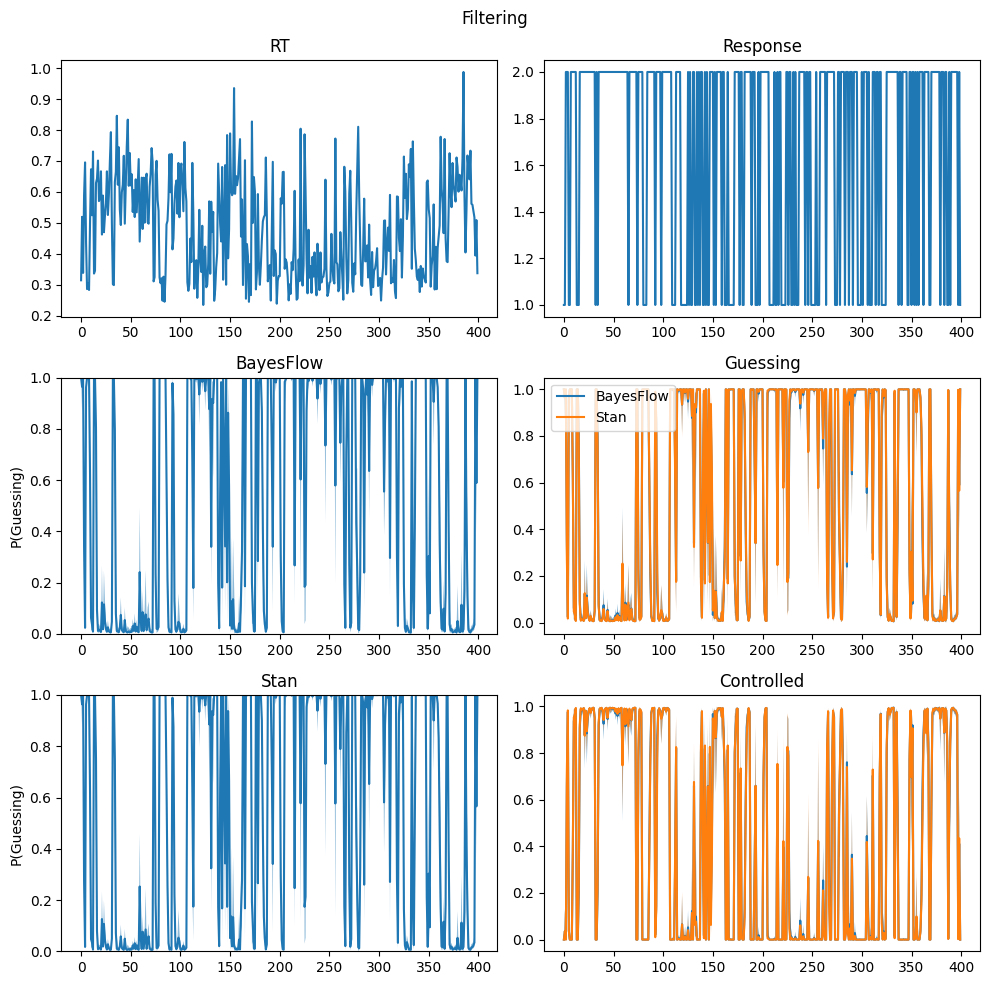

In [14]:
fig, axs = plt.subplots(3, 2)

axs[0, 0].set_title("RT")
axs[2, 1].set_title("Controlled")
axs[1, 0].set_title("BayesFlow")
axs[2, 0].set_title("Stan")
axs[0, 1].set_title("Response")
axs[1, 1].set_title("Guessing")

axs[0, 0].plot(rt)
axs[0, 1].plot(choice)

x = range(len(rt))
for i, method in enumerate(['BayesFlow', 'Stan']):
    axs[i+1, 0].set_ylim([0,1])
    axs[i+1, 0].set_ylabel("P(Guessing)")
    axs[i+1, 0].plot(x, forward[1, i, :, 0])
    axs[i+1, 0].fill_between(x, forward[0, i, :, 0], forward[-1, i, :, 0], alpha = 0.5)
    for j, s in enumerate(['Guessing', 'Controlled']):
        axs[j+1, 1].plot(x, forward[1, i, :, j], label=method)
        axs[j+1, 1].fill_between(x, forward[0, i, :, j], forward[-1, i, :, j], alpha = 0.5)


axs[1,1].legend(loc='upper left')
f=fig.suptitle("Filtering")
fig.tight_layout()

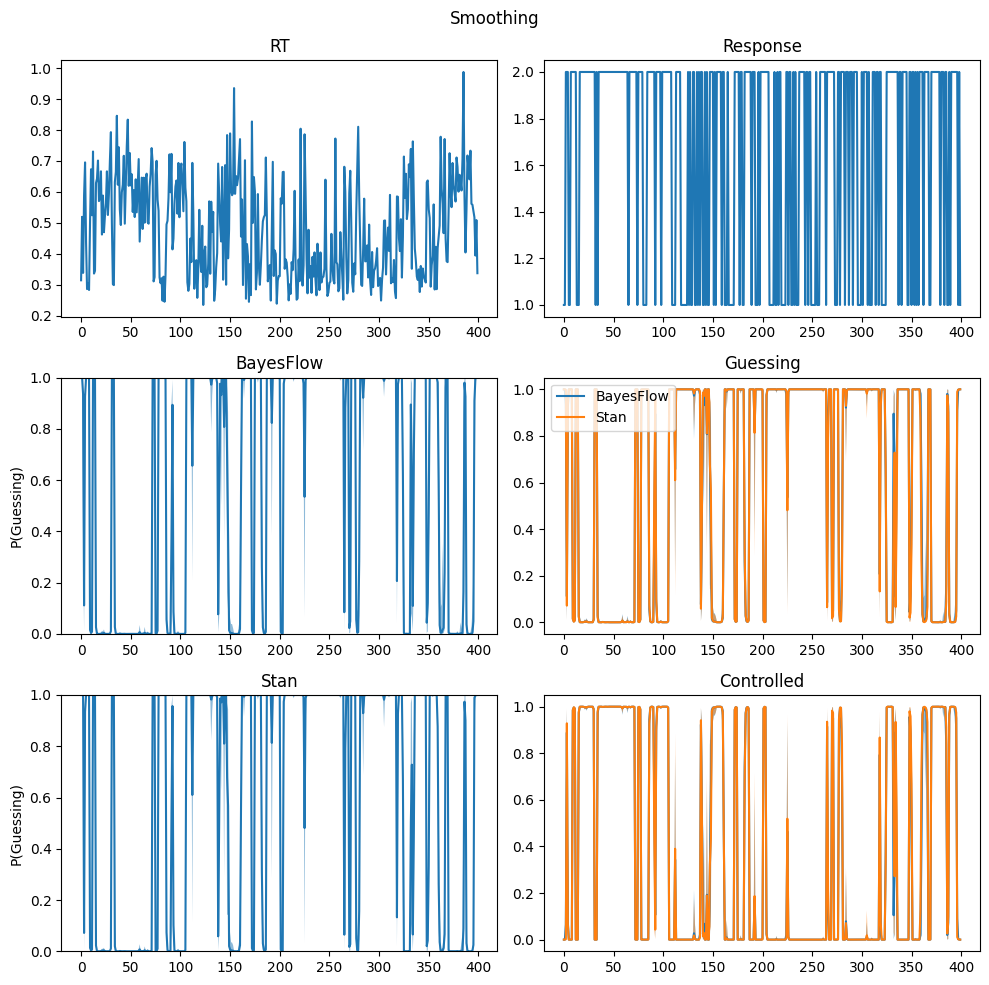

In [15]:
fig, axs = plt.subplots(3, 2)

axs[0, 0].set_title("RT")
axs[2, 1].set_title("Controlled")
axs[1, 0].set_title("BayesFlow")
axs[2, 0].set_title("Stan")
axs[0, 1].set_title("Response")
axs[1, 1].set_title("Guessing")

axs[0, 0].plot(rt)
axs[0, 1].plot(choice)

x = range(len(rt))
for i, method in enumerate(['BayesFlow', 'Stan']):
    axs[i+1, 0].set_ylim([0,1])
    axs[i+1, 0].set_ylabel("P(Guessing)")
    axs[i+1, 0].plot(x, smoothing[1, i, :, 0])
    axs[i+1, 0].fill_between(x, smoothing[0, i, :, 0], smoothing[-1, i, :, 0], alpha = 0.5)
    for j, s in enumerate(['Guessing', 'Controlled']):
        axs[j+1, 1].plot(x, smoothing[1, i, :, j], label=method)
        axs[j+1, 1].fill_between(x, smoothing[0, i, :, j], smoothing[-1, i, :, j], alpha = 0.5)


axs[1,1].legend(loc='upper left')
fig.suptitle("Smoothing")
fig.tight_layout()